# Document Retrieve - Chunking (Manual)

Chunking document manually using LangChain

- Chunking
    - md & text split of md formated texet
- Data analysis (Token size)

## Doucment prep

Azure OpenAI documents (MD formatted)
- https://github.com/MicrosoftDocs/azure-docs/tree/main/articles/ai-services/openai

In [1]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def token_size(text):
    return len(encoding.encode(text))

In [2]:
import os
import pandas as pd
import re

In [3]:
def remove_between_markers(text, start_marker, end_marker):
    # Find the start and end positions of the markers
    start_pos = text.find(start_marker)
    end_pos = text.find(end_marker, start_pos + len(start_marker))
    
    # Remove the content between the markers
    if start_pos != -1 and end_pos != -1:
        return text[:start_pos] + text[end_pos + len(end_marker):]
    else:
        return text

In [4]:
# Create an empty DataFrame with specific column names
df = pd.DataFrame(columns=['file_name', 'size', 'token_size', 'title', 'content'])

for md in os.listdir("./docs"):
    if not os.path.isdir(md):
        with open(f'./docs/{md}', "r") as f:
            text = f.read()

    pattern = r"title:\s*(.*)"
    matches = re.search(pattern, text)

    # get title from header
    title = ""
    if matches:
        title = matches.group(1)
        title = title.replace("'", "")
    else:
        title = md

    # clean header
    text = remove_between_markers(text, "---", "---\n\n")
    
    new_row = {'file_name': md, 'size': len(text), 'token_size': token_size(text), 'title':  title, 'content': text}
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df

,file_name,size,token_size,title,content
0,content-filters.md,13289,2691,How to use content filters (preview) with Azur...,# How to configure content filters with Azure ...
1,dotnet-new-application.md,709,177,dotnet-new-application.md,### Create a new .NET Core application\n\nIn a...
2,fine-tuning-python.md,33086,7734,Customize a model with Azure OpenAI Service an...,## Prerequisites\n\n- Read the [When to use Az...
3,use-your-data-dotnet.md,5775,1210,use-your-data-dotnet.md,[!INCLUDE [Set up required variables](./use-yo...
4,text-to-speech-rest.md,1202,293,text-to-speech-rest.md,"## REST API\n\nIn a bash shell, run the follow..."
...,...,...,...,...,...
133,gpt-v-quickstart.md,654,182,Quickstart: Use GPT-4 Turbo with Vision on you...,# Quickstart: Use images in your AI chats\n\n:...
134,use-your-data-powershell.md,4169,971,use-your-data-powershell.md,[!INCLUDE [Set up required variables](./use-yo...
135,use-your-data-python.md,4593,1084,use-your-data-python.md,[!INCLUDE [Set up required variables](./use-yo...
136,use-your-image-data.md,13966,3096,Use your image data with Azure OpenAI Service ...,# Azure OpenAI on your data with images using ...


## Chunking Comparison

- https://github.com/Azure/azure-search-vector-samples/blob/main/demo-python/code/data-chunking/langchain-data-chunking-example.ipynb
- https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory#auto-detect-file-encodings-with-textloader

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

def get_encoding_name(model="gpt-4o"):
    return tiktoken.encoding_for_model(model).name

In [6]:
# test chunking
#row = df[df['file_name'] == 'use-your-data.md']
row = df[df['file_name'] == 'assistant.md']
# use list function to show all text in the cell
md_content = list(row['content'])[0]
md_content

'# Getting started with Azure OpenAI Assistants (Preview)\n\nAzure OpenAI Assistants (Preview) allows you to create AI assistants tailored to your needs through custom instructions and augmented by advanced tools like code interpreter, and custom functions. In this article we\'ll provide an in-depth walkthrough of getting started with the Assistants API.\n\n## Assistants support\n\n### Region and model support\n\nThe [models page](../concepts/models.md#assistants-preview) contains the most up-to-date information on regions/models where Assistants are currently supported.\n\n### API Version\n\n- `2024-02-15-preview`\n\n### Supported file types\n\n|File format|MIME Type|Code Interpreter |\n|---|---|---|\n|.c| text/x-c |✅|\n|.cpp|text/x-c++ |✅|\n|.csv|application/csv|✅|\n|.docx|application/vnd.openxmlformats-officedocument.wordprocessingml.document|✅|\n|.html|text/html|✅|\n|.java|text/x-java|✅|\n|.json|application/json|✅|\n|.md|text/markdown| ✅ |\n|.pdf|application/pdf|✅|\n|.php|text/x-ph

In [7]:
headers_to_split_on = [
    ("#", "H1"),
    ("##", "H2"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(md_content)
len(md_header_splits)

8

In [8]:
for j, md_split in enumerate(md_header_splits):
    if 'H1' in md_split.metadata:
        if 'H2' in md_split.metadata:
            chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
        else:
            chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
    else:
        chunk = md_split.page_content
    print(j, token_size(chunk))

0 65
1 476
2 43
3 215
4 6348
5 377
6 516
7 69


In [9]:
# Char-level splits
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name=get_encoding_name(),
    chunk_size=1200, 
    chunk_overlap=125
)

# Split
splits = text_splitter.split_documents(md_header_splits)
len(splits)

16

In [10]:
for j, md_split in enumerate(splits):
    if 'H1' in md_split.metadata:
        if 'H2' in md_split.metadata:
            chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
        else:
            chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
    else:
        chunk = md_split.page_content
    print(j, token_size(chunk))

0 65
1 476
2 43
3 215
4 312
5 1183
6 1167
7 411
8 1189
9 280
10 1107
11 927
12 109
13 377
14 516
15 69


## MD Chunking

In [11]:
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_header_splits = markdown_splitter.split_text(md_content)
len(md_header_splits)

chunked_data = pd.DataFrame(columns=['title', 'chunk', 'parent_id', 'chunk_id', 'token_size'])

for i in range(len(df)):
    row = df.iloc[i]

    md_content = row['content']
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    md_header_splits = markdown_splitter.split_text(md_content)

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        encoding_name=get_encoding_name(),
        chunk_size=1000, 
        chunk_overlap=125
    )

    # Split
    splits = text_splitter.split_documents(md_header_splits)

    for j, md_split in enumerate(splits):
        try:
            if 'H1' in md_split.metadata:
                if 'H2' in md_split.metadata:
                    chunk = f"## {md_split.metadata['H2']}\n{md_split.page_content}"
                else:
                    chunk = f"# {md_split.metadata['H1']}\n{md_split.page_content}"
            else:
                chunk = md_split.page_content
            new_row = {'title':  row['title'], 'chunk': chunk, 'parent_id': row['file_name'], 'chunk_id': j, 'token_size': token_size(chunk)}
            chunked_data = pd.concat([chunked_data, pd.DataFrame([new_row])], ignore_index=True)
        
        except Exception as e:
            print(f"Error: {i}, {j}, {e}\n{md_split.metadata}")


chunked_data

,title,chunk,parent_id,chunk_id,token_size
0,How to use content filters (preview) with Azur...,# How to configure content filters with Azure ...,content-filters.md,0,952
1,How to use content filters (preview) with Azur...,# How to configure content filters with Azure ...,content-filters.md,1,276
2,How to use content filters (preview) with Azur...,## Configuring content filters via Azure OpenA...,content-filters.md,2,958
3,How to use content filters (preview) with Azur...,## Configuring content filters via Azure OpenA...,content-filters.md,3,506
4,How to use content filters (preview) with Azur...,## Best practices\nWe recommend informing your...,content-filters.md,4,132
...,...,...,...,...,...
1113,Use your image data with Azure OpenAI Service ...,## Additional Tips\n### Adding and Removing Da...,use-your-image-data.md,8,201
1114,Use your image data with Azure OpenAI Service ...,## Next steps\n- You can also chat on Azure Op...,use-your-image-data.md,9,113
1115,use-your-data-go.md,[!INCLUDE [Set up required variables](./use-yo...,use-your-data-go.md,0,18
1116,use-your-data-go.md,1. Create a new folder named *openai-go* for y...,use-your-data-go.md,1,102


In [12]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra

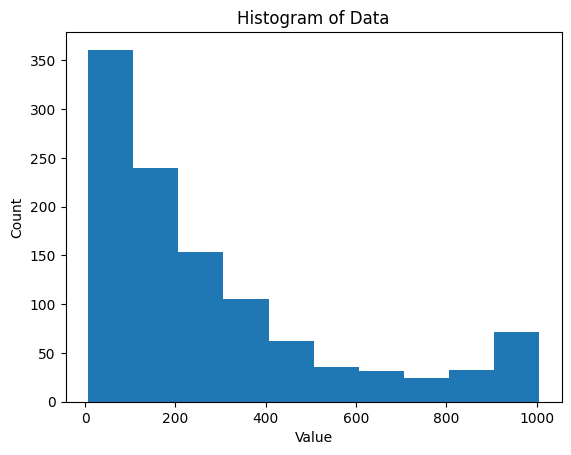

In [13]:
# chatgpt promt: "python code to plot a graph group by count of bin size from data"
data = chunked_data['token_size']

bin_size = 100

# Calculate the number of bins based on the bin size
num_bins = int(np.ceil((data.max() - data.min()) / bin_size))

# Create the histogram
plt.hist(data, bins=num_bins)

# Set the axis labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of Data')

# Show the plot
plt.show()

In [14]:
# file with token size > 2K
len(chunked_data[chunked_data['token_size'] > 2000])

0

In [ ]:
# save to file
#chunked_data.to_pickle('./aoai-docs_md.pkl')